In [26]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

import data_utils as HIVLoader
from elemBERT.model import ElemBERTModel

## Load Datasets

In [27]:
df = pd.read_csv('elemBERT/HIVV1_ds.csv')
df['typesV1'] = df['typesV1'].apply(eval)
df.head()

,Unnamed: 0,typesV1,ids,formula,labels
0,0,"[C1, C5, C3, O0, Cu1, O0, C3, C5, C1, C5, O0, ...",0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,1,"[C3, C3, C0, C3, C3, C3, C3, C3, C3, O0, Cu1, ...",1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,2,"[C1, C3, O0, N1, C0, C3, C3, C3, C3, C0, S2, C...",2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,3,"[N3, C0, C3, C3, C0, C3, C3, C0, C3, C3, C0, N...",3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,4,"[O0, S6, O0, O2, C5, C5, S6, O0, O0, O2, H0, H...",4,O=S(=O)(O)CCS(=O)(=O)O,0


## Data Preparation

In [28]:
element2id = pickle.load(open('elemBERT/models/pretrained/el2idV1.pkl', 'rb'))['el2id']
vocab_size = len(element2id)
print('Element vocab size:', vocab_size)

Element vocab size: 565


In [29]:
add_special_token = lambda xs: ['[CLS]', *xs, '[SEP]']
tokenize_type = lambda xs: [element2id[x] for x in xs]
pad_sequence = lambda xs: tf.keras.preprocessing.sequence.pad_sequences([xs],
                                                                        dtype='int32',
                                                                        padding= 'post',
                                                                        truncating='post',
                                                                        maxlen=256)[0]

df['tokens']  = df['typesV1'].apply(add_special_token).apply(tokenize_type).apply(pad_sequence)
df.head()

,Unnamed: 0,typesV1,ids,formula,labels,tokens
0,0,"[C1, C5, C3, O0, Cu1, O0, C3, C5, C1, C5, O0, ...",0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0,"[3, 71, 75, 73, 308, 132, 308, 73, 75, 71, 75,..."
1,1,"[C3, C3, C0, C3, C3, C3, C3, C3, C3, O0, Cu1, ...",1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0,"[3, 73, 73, 70, 73, 73, 73, 73, 73, 73, 308, 1..."
2,2,"[C1, C3, O0, N1, C0, C3, C3, C3, C3, C0, S2, C...",2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0,"[3, 71, 73, 308, 267, 70, 73, 73, 73, 73, 70, ..."
3,3,"[N3, C0, C3, C3, C0, C3, C3, C0, C3, C3, C0, N...",3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0,"[3, 269, 70, 73, 73, 70, 73, 73, 70, 73, 73, 7..."
4,4,"[O0, S6, O0, O2, C5, C5, S6, O0, O0, O2, H0, H...",4,O=S(=O)(O)CCS(=O)(=O)O,0,"[3, 308, 422, 308, 310, 75, 75, 422, 308, 308,..."


In [30]:
train_ds, val_ds, test_ds = HIVLoader.random_split(df, x_col='tokens', y_col='labels', id_col='formula', undersampling=True)

print(f'total: {len(train_ds):5d}, active: {sum(train_ds.y):4d}, inactive: {sum(train_ds.y == False):5d}')
print(f'total: {len(val_ds):5d}, active: {sum(val_ds.y):4d}, inactive: {sum(val_ds.y == False):5d}')
print(f'total: {len(test_ds):5d}, active: {sum(test_ds.y):4d}, inactive: {sum(test_ds.y == False):5d}')

total:  2014, active: 1010, inactive:  1004
total:   576, active:  293, inactive:   283
total:   288, active:  136, inactive:   152


## Model

In [55]:
class Config:
  MAX_LEN = 256
  BATCH_SIZE = 32
  LR = 0.0001
  VOCAB_SIZE = vocab_size
  EMBED_DIM = 32
  NUM_HEAD = 2 # used in bert model
  FF_DIM = 32 # used in bert model
  NUM_LAYERS = 2
  MNAME = 'elembert_'
  MVER = 'V1'
  
config = Config()
model = ElemBERTModel(Config, out=2, out_act='softmax')

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.BinaryCrossentropy())
model.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ types (InputLayer)  │ (None, 256)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ element_embdgs      │ (None, 256, 32)   │     18,080 │ types[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 256, 32)   │          0 │ element_embdgs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__multihe… │ (None, 256, 32)   │      4,224 │ add_15[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_15[0][0],     │
│                     │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__att_dro… │ (None, 256, 32)   │          0 │ encoder_0__multi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 256, 32)   │          0 │ add_15[0][0],     │
│                     │                   │            │ encoder_0__att_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__att_lay… │ (None, 256, 32)   │         64 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__ffn      │ (None, 256, 32)   │      2,112 │ encoder_0__att_l… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__ffn_dro… │ (None, 256, 32)   │          0 │ encoder_0__ffn[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 256, 32)   │          0 │ encoder_0__att_l… │
│                     │                   │            │ encoder_0__ffn_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0__ffn_lay… │ (None, 256, 32)   │         64 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__multihe… │ (None, 256, 32)   │      4,224 │ encoder_0__ffn_l… │
│ (MultiHeadAttentio… │                   │            │ encoder_0__ffn_l… │
│                     │                   │            │ encoder_0__ffn_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__att_dro… │ (None, 256, 32)   │          0 │ encoder_1__multi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 256, 32)   │          0 │ encoder_0__ffn_l… │
│                     │                   │            │ encoder_1__att_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__att_lay… │ (None, 256, 32)   │         64 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__ffn      │ (None, 256, 32)   │      2,112 │ encoder_1__att_l… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1__ffn_dro… │ (None, 256, 32)   │          0 │ encoder_1__ffn[0

 Total params: 31,074 (121.38 KB)

 Trainable params: 31,074 (121.38 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
def convert_ds(ds):
  X = np.array([*ds.X])
  y = tf.one_hot(ds.y, 2)
  return X, y

X_train, y_train = convert_ds(train_ds)
X_val, y_val = convert_ds(val_ds)
X_test, y_test = convert_ds(test_ds)

In [57]:
class TestCallback(tf.keras.callbacks.Callback):
  def __init__(self, test_dataset):
    super().__init__()
    self.test_dataset = test_dataset

  def on_epoch_end(self, epoch, logs=None):
    X, ylog = self.test_dataset
    y = np.argmax(ylog, axis=1)
    
    logits = self.model.predict(X)
    preds = np.argmax(logits, axis=1)
    
    roc_auc = roc_auc_score(ylog, logits)
    f1 = f1_score(y, preds)
    recall = recall_score(y, preds)
    acc = accuracy_score(y, preds)
    
    logs['val_roc_auc'] = roc_auc
    logs['val_f1'] = f1
    logs['val_recall'] = recall
    logs['val_acc'] = acc

In [75]:
best_auc_path = os.path.join('checkpoints', 'elemBERT_undersampled', 'best_roc_auc_score', 'checkpoint.keras')
best_f1_path = os.path.join('checkpoints', 'elemBERT_undersampled', 'best_f1_score', 'checkpoint.keras')
best_recall_path = os.path.join('checkpoints', 'elemBERT_undersampled', 'best_recall_score', 'checkpoint.keras')
model_path = os.path.join('checkpoints', 'elemBERT_undersampled', 'checkpoint.keras')

In [67]:
history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_val, y_val),
                    verbose=1, epochs=300, batch_size=32,
                    callbacks=[
                      TestCallback((X_val, y_val)),
                      tf.keras.callbacks.ModelCheckpoint(best_auc_path, monitor='val_roc_auc', save_best_only=True, mode='max', verbose=1),
                      tf.keras.callbacks.ModelCheckpoint(best_f1_path, monitor='val_f1', save_best_only=True, mode='max', verbose=1),
                      tf.keras.callbacks.ModelCheckpoint(best_recall_path, monitor='val_recall', save_best_only=True, mode='max', verbose=1)
                    ])

Epoch 1/300
 1/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5949

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.61

Epoch 1: val_roc_auc improved from -inf to 0.69311, saving model to checkpoints/elemBERT_undersampled/best_roc_auc_score/checkpoint.keras

Epoch 1: val_f1 improved from -inf to 0.63763, saving model to checkpoints/elemBERT_undersampled/best_f1_score/checkpoint.keras

Epoch 1: val_recall improved from -inf to 0.62457, saving model to checkpoints/elemBERT_undersampled/best_recall_score/checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6172 - val_loss: 0.6341 - val_roc_auc: 0.6931 - val_f1: 0.6376 - val_recall: 0.6246 - val_acc: 0.6389
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.61

Epoch 2: val_roc_auc improved from 0.69311 to 0.69368, saving model to checkpoints/elemBERT_undersampled/best_roc_auc_score/checkpoint.keras

Epoch 2: val_f1 did not improve from 0.63763

Epoch 2: val_recall did not improve from 0.62457
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6126 - val_loss: 0.6349 - val_roc_auc: 0.

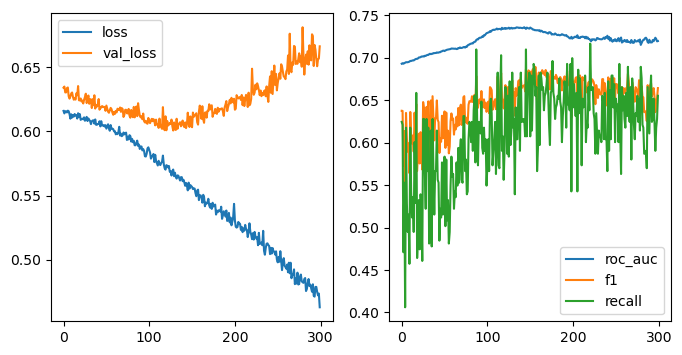

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(history.history['val_roc_auc'])
axs[1].plot(history.history['val_f1'])
axs[1].plot(history.history['val_recall'])
axs[1].legend(['roc_auc', 'f1', 'recall'])

plt.show()

## Evaluation

In [69]:
def eval_model(model, X_test, y_test):
  logits = model.predict(X_test)
  preds = np.argmax(logits, axis=1)
  y = np.argmax(y_test, axis=1)
  
  roc_auc = roc_auc_score(y_test, logits)
  f1 = f1_score(y, preds)
  recall = recall_score(y, preds)
  acc = accuracy_score(y, preds)

  print('roc-auc:', roc_auc)
  print('f1:', f1)
  print('accuracy:', acc)
  print('recall:', recall)

  cm = confusion_matrix(test_ds.y, preds, normalize='true')
  disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm)

  cm = confusion_matrix(test_ds.y, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  disp_norm.plot(ax=axs[0])
  disp.plot(ax=axs[1])
  plt.tight_layout() 
  plt.plot()

### Evaluate model on last epoch

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


roc-auc: 0.7059307275541795
f1: 0.6346863468634686
accuracy: 0.65625
recall: 0.6323529411764706


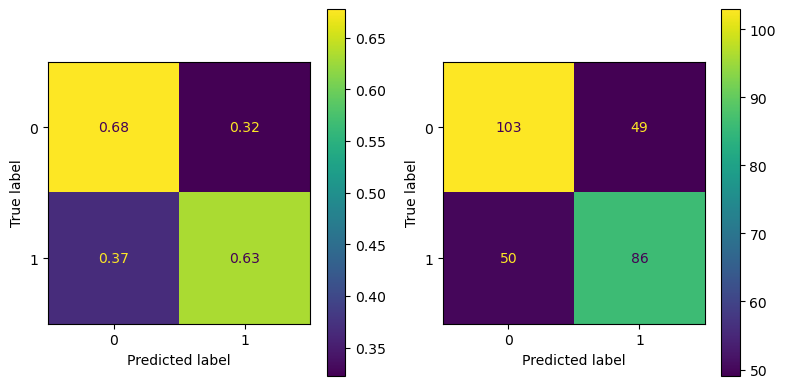

In [76]:
model.save(model_path)
eval_model(model, X_test, y_test)

### Evaluate model with best AUC score

In [71]:
tf.keras.config.enable_unsafe_deserialization()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
roc-auc: 0.7137190402476781
f1: 0.627906976744186
accuracy: 0.6666666666666666
recall: 0.5955882352941176


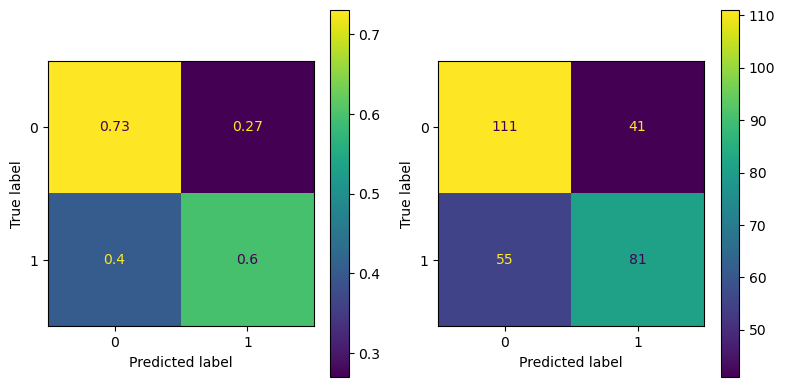

In [72]:
auc_model = tf.keras.models.load_model(best_auc_path)
eval_model(auc_model, X_test, y_test)

### Test on model with best F1 score

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
roc-auc: 0.7155572755417957
f1: 0.6335877862595419
accuracy: 0.6666666666666666
recall: 0.6102941176470589


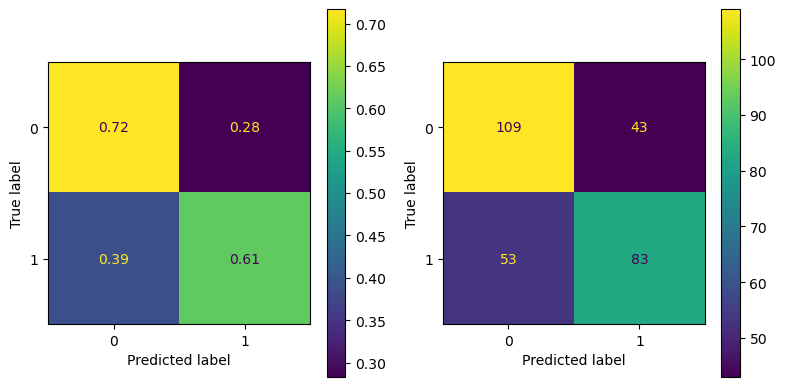

In [73]:
f1_model = tf.keras.models.load_model(best_f1_path)
eval_model(f1_model, X_test, y_test)

### Evaluate model with best recall score

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
roc-auc: 0.6998355263157895
f1: 0.6312292358803987
accuracy: 0.6145833333333334
recall: 0.6985294117647058


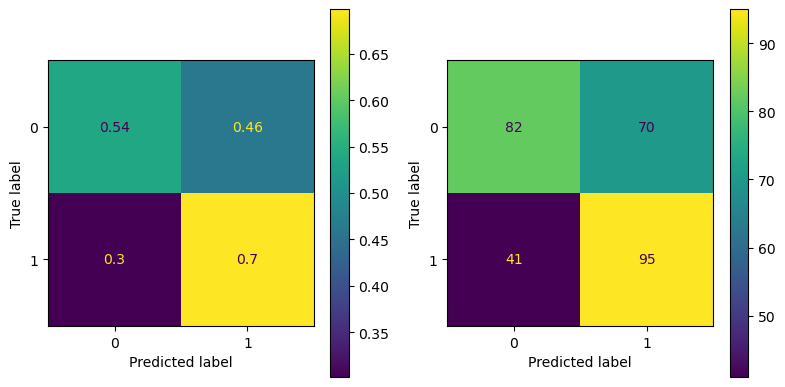

In [74]:
recall_model = tf.keras.models.load_model(best_recall_path)
eval_model(recall_model, X_test, y_test)